# 의사결정나무

In [18]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pydotplus
import graphviz
from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#경고 무시
import warnings 
warnings.filterwarnings('ignore')

matplotlib.rc('font',family='Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)

In [19]:
df = pd.read_csv("./실습화일/1 Big Data 분석 기초/체질검사.csv", encoding = 'euc-kr')
# display(df.head())
# df.isnull().sum()

#'WEIGHT', 'HEIGHT' 뒤의 단위를 잘라준 후, float로 데이터 타입 지정 
df[['WEIGHT','WEIGHT_UNIT']] = df['WEIGHT'].str.split(expand=True)
df[['HEIGHT','HEIGHT_UNIT']] = df['HEIGHT'].str.split(expand=True)
df['WEIGHT'] = df['WEIGHT'].astype('float64')
df['HEIGHT'] = df['HEIGHT'].astype('float64')

# 단위 항목 제거
df=df.drop(['WEIGHT_UNIT','HEIGHT_UNIT'],axis = 1)
df_dummy = pd.get_dummies(df,drop_first=True)
df_dummy.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1


In [20]:
# 목표변수, 설명변수 설정
df_y = df_dummy['FAT']
df_x = df_dummy.drop('FAT', axis = 1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (176, 14)
train data Y size: (176,)
test data X size: (76, 14)
test data Y size: (76,)


In [21]:
# train accuracy 와 test accuracy gap 차이가 매우 큼. 과적합 발생
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.404


In [22]:
# 잎사귀 노드 최소 자료수 조정
train_score = []
test_score=[]

para_leaf = [n_leaf * 1 for n_leaf in range(1,20)] # = [1,2...,19,20]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234, 
                                 min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.404
1,2,0.970,0.362
2,3,0.928,0.452
3,4,0.904,0.454
4,5,0.869,0.449
5,6,0.853,0.451
6,7,0.843,0.465
7,8,0.830,0.536
8,9,0.802,0.477
9,10,0.793,0.505


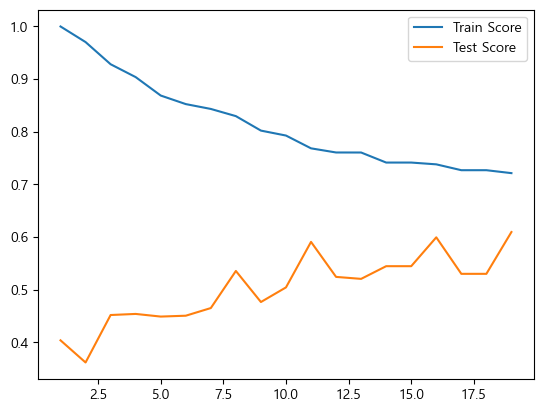

In [23]:
plt.plot(para_leaf, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle ="-", label = "Test Score")
plt.legend()

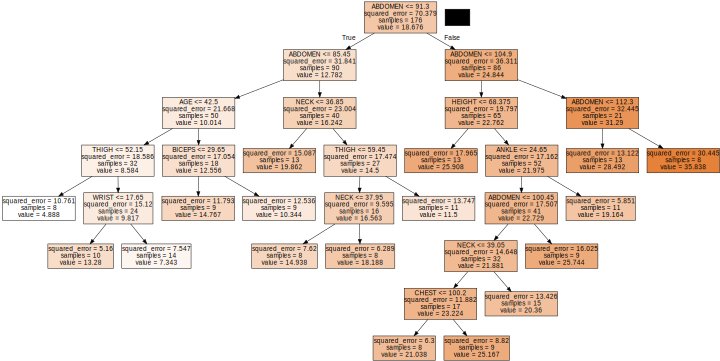

In [24]:
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_leaf.dot",
               feature_names=v_feature_name, impurity = True, filled = True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()

pydot_graph = pydotplus.graph_from_dot_data(dot_graph)
pydot_graph.set_size('"10,9!"')
pydot_graph.write_png('tree_leaf.png')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

In [25]:
# 분리 노드 최소 자료수 조정
train_score = []
test_score=[]

para_split = [n_split * 2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, 
                                 min_samples_leaf=8, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.830,0.536
1,6,0.830,0.536
2,8,0.830,0.536
3,10,0.830,0.536
4,12,0.830,0.536
5,14,0.830,0.536
6,16,0.830,0.536
7,18,0.821,0.557
8,20,0.813,0.581
9,22,0.792,0.567


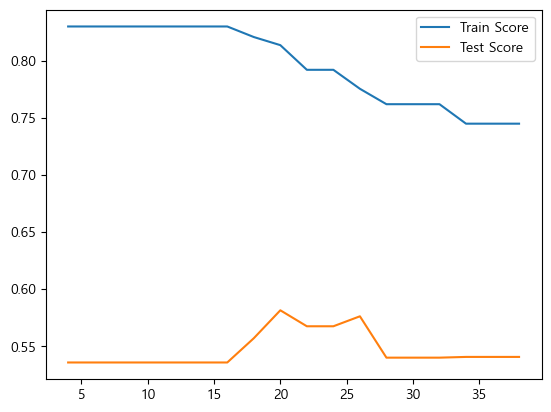

In [26]:
plt.plot(para_split, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle ="-", label = "Test Score")
plt.legend()

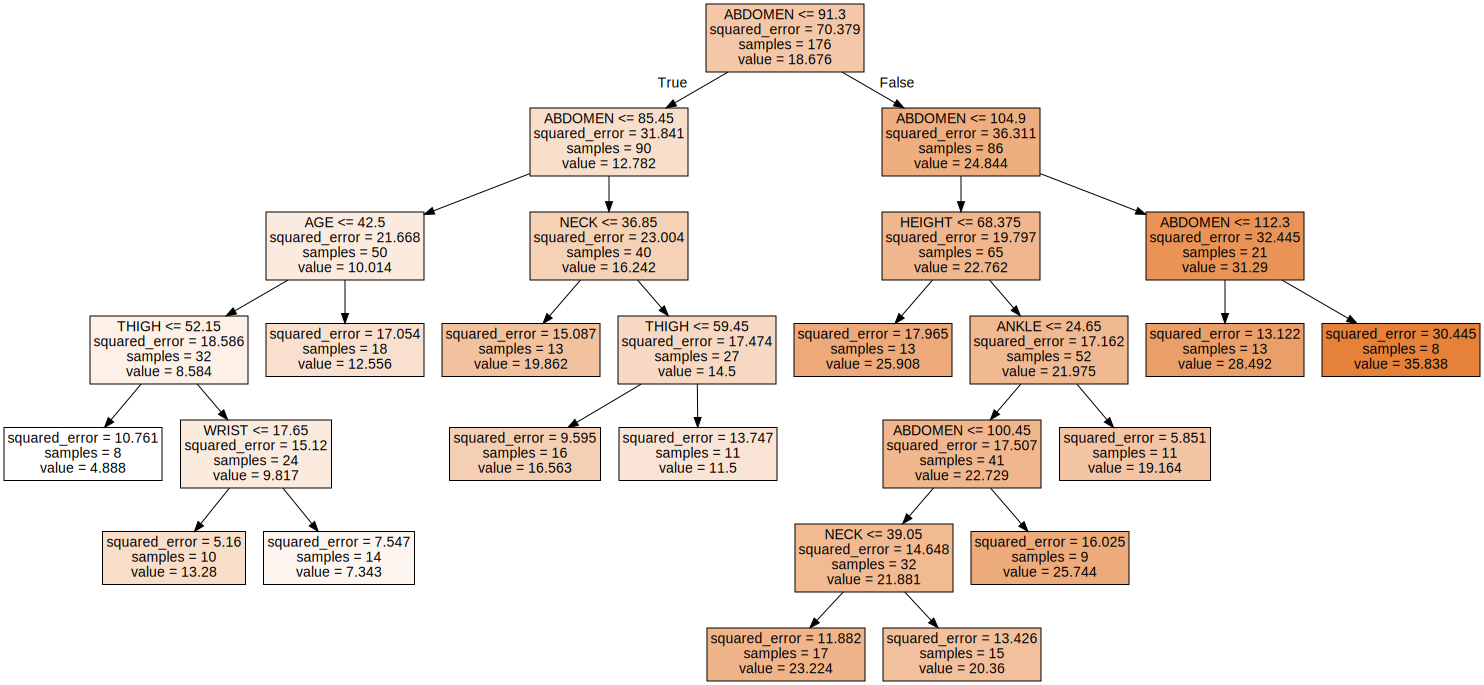

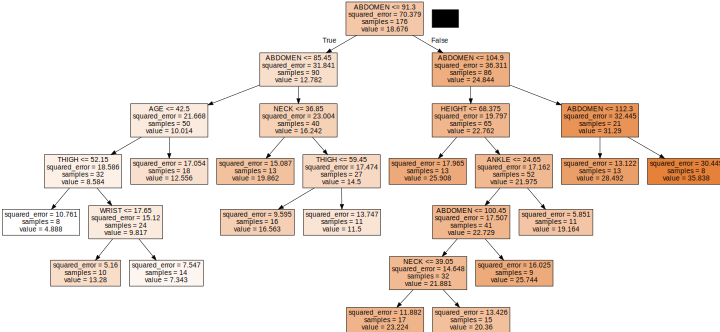

In [27]:
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8, min_samples_split=20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_split.dot",
               feature_names=v_feature_name, impurity = True, filled = True)
with open("tree_split.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

pydot_graph = pydotplus.graph_from_dot_data(dot_graph)
pydot_graph.set_size('"10,9!"')
pydot_graph.write_png('tree_split.png')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

In [28]:
# 최대 깊이 조정
train_score = []
test_score=[]

para_depth = [depth  for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, 
                                 min_samples_leaf=8, min_samples_split=20, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth["MinSamplesLeaf"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.517,0.333
1,2,0.679,0.569
2,3,0.749,0.538
3,4,0.783,0.570
4,5,0.808,0.581
5,6,0.813,0.581
6,7,0.813,0.581
7,8,0.813,0.581
8,9,0.813,0.581
9,10,0.813,0.581


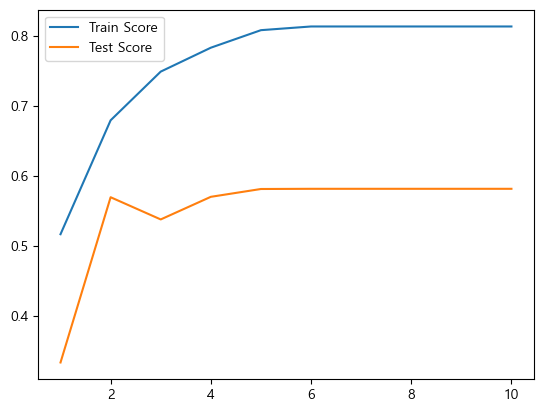

In [29]:
plt.plot(para_depth, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle ="-", label = "Test Score")
plt.legend()

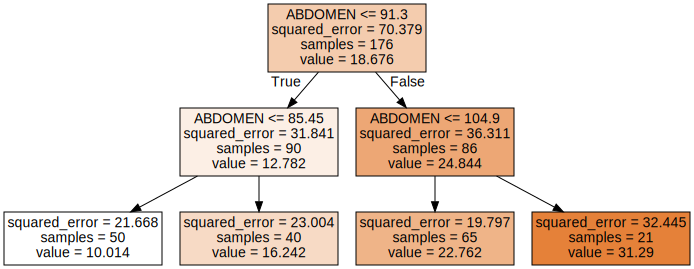

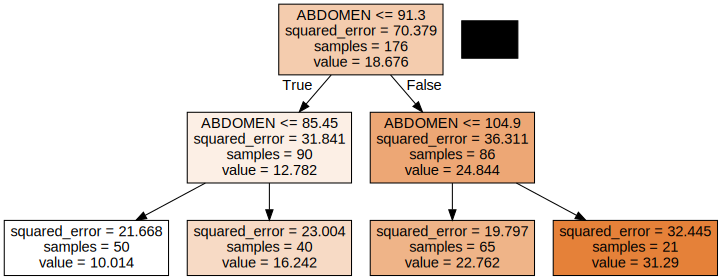

In [30]:
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8,min_samples_split=20, max_depth = 2)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_depth.dot",
               feature_names=v_feature_name, impurity = True, filled = True)
with open("tree_depth.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))
pydot_graph = pydotplus.graph_from_dot_data(dot_graph)
pydot_graph.set_size('"10,9!"')
pydot_graph.write_png('tree_depth.png')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

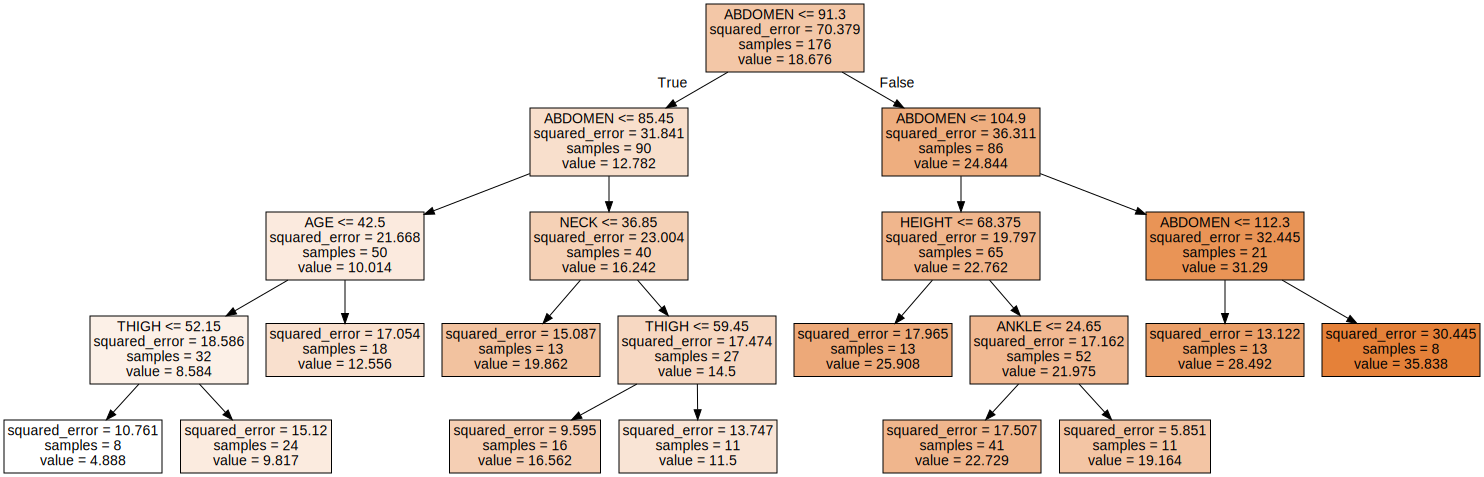

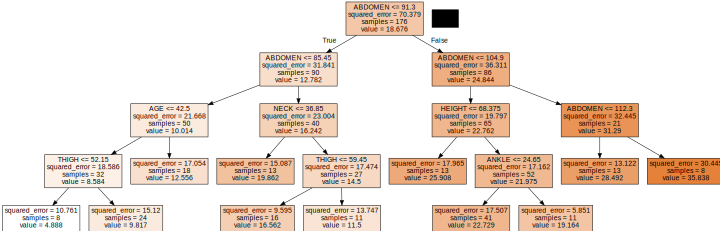

In [31]:
# 최종 모델
tree_fianl = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8,min_samples_split=20,max_depth=4)
tree_fianl.fit(df_train_x, df_train_y)

export_graphviz(tree_fianl, out_file="tree_final.dot",
               feature_names=v_feature_name, impurity=True, filled = True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

pydot_graph = pydotplus.graph_from_dot_data(dot_graph)
pydot_graph.set_size('"10,9!"')
pydot_graph.write_png('tree_final.png')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

In [32]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_fianl.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.895
7,THIGH,0.032
3,NECK,0.026
0,AGE,0.019
2,HEIGHT,0.017
9,ANKLE,0.011
1,WEIGHT,0.000
4,CHEST,0.000
6,HIP,0.000
8,KNEE,0.000


Text(0, 0.5, '변수')

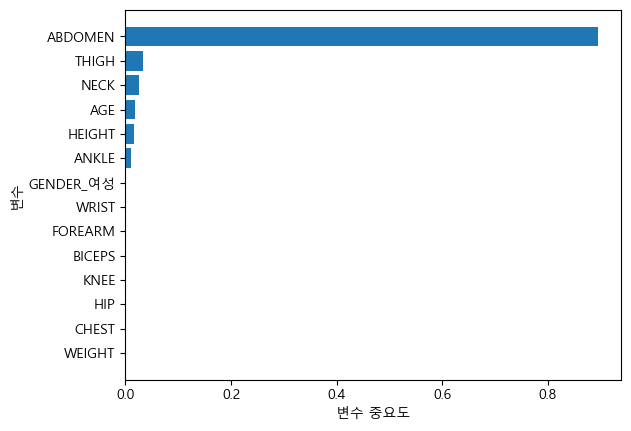

In [33]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### gridsearchCV를 이용하면 모델링 할 때마다 값이 변화

여러번 모델링 한 결과 파라미터는 달라도 정확도는 비슷함

randomized search cv 도 존재

In [35]:
estimator = DecisionTreeRegressor()
param_grid = {"criterion":["mse","friedman_mse","mae"], "max_features":["auto","sqrt","log2"],
             "max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}

# n_jobs = 전체 코어 사용하시오
grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs=-1)
grid_dt.fit(df_train_x,df_train_y)

print("best estimator model:\n{}".format(grid_dt.best_estimator_))
print("\nbest parameter:\n{}".format(grid_dt.best_params_))
print("\nbest score:\n{}".format(grid_dt.best_score_))

best estimator model:
DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto', min_samples_leaf=18,
                      min_samples_split=38)

best parameter:
{'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 38}

best score:
0.5976341360924463


최대깊이 5, 노드 최소 샘플 수 18개, 최소 분리 노드수 38개 일 때, 설명력 59.8%